# Notes for user:

*   This notebook will use the dataset COVID-19 (positive cases and death rates) and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to buy the GBP.
*   Therefore, we look at the death rates & positive cases in the US.
*   We are looking at dates: 31st Dec 2019 - 31st July 2020.
*   LSTMs are good at looking at changed over time. 


# Part 1B: Multivariate Linear Regression
Using COVID-19 Death Rates, Positive Cases and Forex price as input into a Multivariate Linear Regression model to predict Forex Spot Price of that currency pair.


*   [Univariate & Multivariate](https://donaldpinckney.com/books/tensorflow/book/ch2-linreg/2018-03-21-multi-variable.html)
*   [Univariate & Multivariate](https://medium.com/themlblog/multivariate-regression-using-deep-neural-networks-in-tensorflow-f94f42a148b3)
*   [*Univariate & Multivariate*](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)


* Plot graph

# Imports

In [60]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# metrics
import math
# to create model
from sklearn.linear_model import LinearRegression

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7d2zgnj9
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-7d2zgnj9
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0bdac38dae54b25c1d06acac83162b271e26545aa_-cp36-none-any.whl size=133239 sha256=03fd64c83b683fa1f6299d787906d62ae78a6c8a5ba765252634c672e3bb97d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ny2l43lt/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [61]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [62]:
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['date', 'total_cases', 'total_deaths']]
us_death_rates.head()

,date,total_cases,total_deaths
32403,2019-12-31,0.0,0.0
32404,2020-01-01,0.0,0.0
32405,2020-01-02,0.0,0.0
32406,2020-01-03,0.0,0.0
32407,2020-01-04,0.0,0.0


In [63]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
forex_dataset = pd.DataFrame(forex_dataset,columns=['Price','Date'])
# forex_dataset = forex_dataset_data.dropna()


In [64]:
# Why are these different?
print(us_death_rates.shape), print(forex_dataset.shape)

(218, 3)
(214, 2)


(None, None)

# Data Preprocessing / Data Cleaning & Collating
*   Eliminating columns we dont want
*   Merging tables based on 'Date' column
*   Dates in question: Dec 31 2019 - Jul 31, 2020
*   Once complete we pop the 'date' we merged on 

In [65]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,date,total_cases,total_deaths
32403,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0
32404,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0
32405,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0
32406,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0
32407,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0


In [66]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Price,Date
209,1.3169,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)"
210,1.3088,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)"
211,1.3146,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)"
212,1.3255,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)"
213,1.3261,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)"


In [67]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
print(dataset)
len(dataset)

      Price                                 Date  ... total_cases  total_deaths
0    1.3090   (2020, 7, 31, 0, 0, 0, 4, 213, -1)  ...   4495014.0      152070.0
1    1.3095   (2020, 7, 30, 0, 0, 0, 3, 212, -1)  ...   4426982.0      150713.0
2    1.2996   (2020, 7, 29, 0, 0, 0, 2, 211, -1)  ...   4351997.0      149256.0
3    1.2932   (2020, 7, 28, 0, 0, 0, 1, 210, -1)  ...   4290263.0      148011.0
4    1.2882   (2020, 7, 27, 0, 0, 0, 0, 209, -1)  ...   4234020.0      146935.0
..      ...                                  ...  ...         ...           ...
209  1.3169      (2020, 1, 4, 0, 0, 0, 5, 4, -1)  ...         0.0           0.0
210  1.3088      (2020, 1, 3, 0, 0, 0, 4, 3, -1)  ...         0.0           0.0
211  1.3146      (2020, 1, 2, 0, 0, 0, 3, 2, -1)  ...         0.0           0.0
212  1.3255      (2020, 1, 1, 0, 0, 0, 2, 1, -1)  ...         0.0           0.0
213  1.3261  (2019, 12, 31, 0, 0, 0, 1, 365, -1)  ...         0.0           0.0

[214 rows x 5 columns]


214

In [68]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
209        (2020, 1, 4, 0, 0, 0, 5, 4, -1)
210        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
211        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
212        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
213    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 214, dtype: object

In [69]:
dataset.head()


,Price,Date,total_cases,total_deaths
0,1.3090,"(2020, 7, 31, 0, 0, 0, 4, 213, -1)",4495014.0,152070.0
1,1.3095,"(2020, 7, 30, 0, 0, 0, 3, 212, -1)",4426982.0,150713.0
2,1.2996,"(2020, 7, 29, 0, 0, 0, 2, 211, -1)",4351997.0,149256.0
3,1.2932,"(2020, 7, 28, 0, 0, 0, 1, 210, -1)",4290263.0,148011.0
4,1.2882,"(2020, 7, 27, 0, 0, 0, 0, 209, -1)",4234020.0,146935.0


# Plotting Features before Normalisation

## Organising date for plotting

In [70]:
# View what date looks like
# Splitting timestamp and isolating the date
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)

      new_date
0   2019-12-31
1   2020-01-01
2   2020-01-02
3   2020-01-03
4   2020-01-04
..         ...
209 2020-07-27
210 2020-07-28
211 2020-07-29
212 2020-07-30
213 2020-07-31

[214 rows x 1 columns]


In [71]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
# print(my_xticks)

## Plotting Forex Spot Price

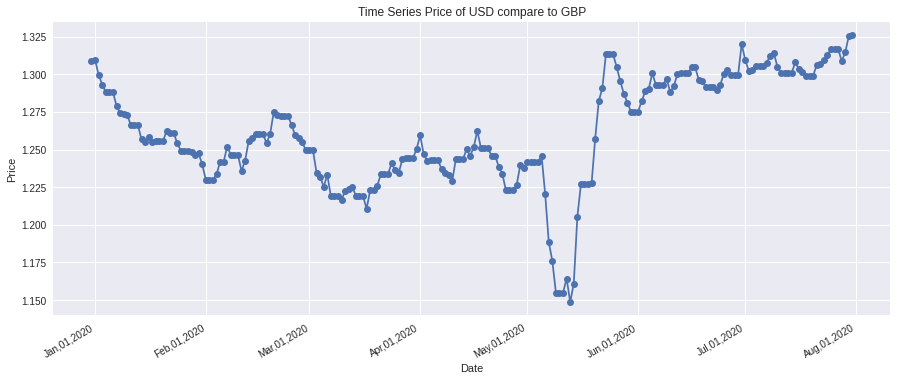

In [72]:
# Plotted prices and dates
# Notice how the dates start and end

rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

## Plotting Accumulative Covid Deaths

In [73]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDayDeaths = 0
dayDeaths = []
for currentday in reversed_arr:
   newDayDeaths = currentday + newDayDeaths
   dayDeaths.append(newDayDeaths)


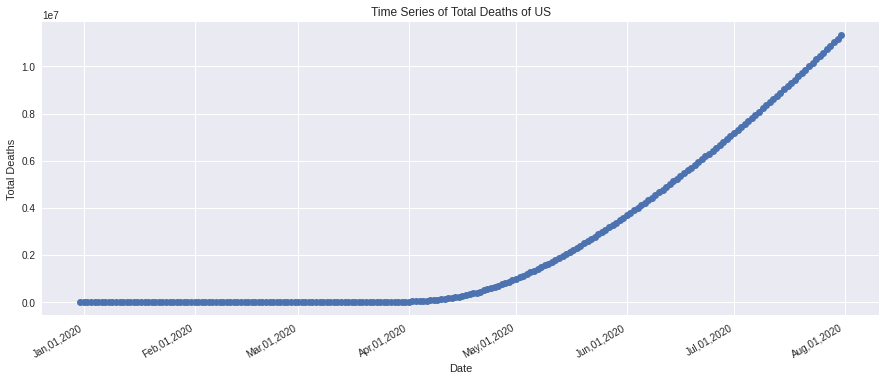

In [74]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(dayDeaths)
plt.plot_date(dates, us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



## Plotting Accumulative Positive Cases

In [75]:
# Adds accumulative positive cases everyday
total_us_cases = dataset['total_cases']
list_arr = np.array(total_us_cases)
reversed_arr = list_arr[::-1]
newDayCases = 0
dayCases = []
for currentday in reversed_arr:
   newDayCases = currentday + newDayCases
   dayCases.append(newDayCases)

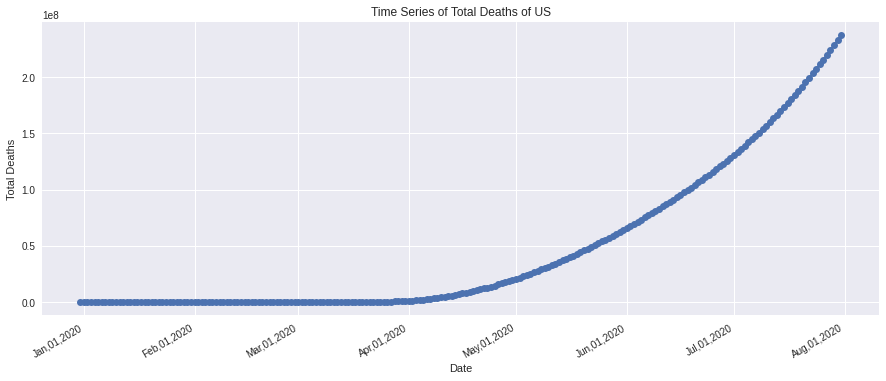

In [76]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_cases = np.array(dayCases)
plt.plot_date(dates, us_cases, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [77]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([dayDeaths]), columns= ["Total_Deaths_US"])
cases_frame = pd.DataFrame(np.concatenate([dayCases]), columns= ["Total_Cases_US"])
# price_frame.append(death_frame)

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_us_cases = scaler.fit_transform(cases_frame).reshape(-1,1)


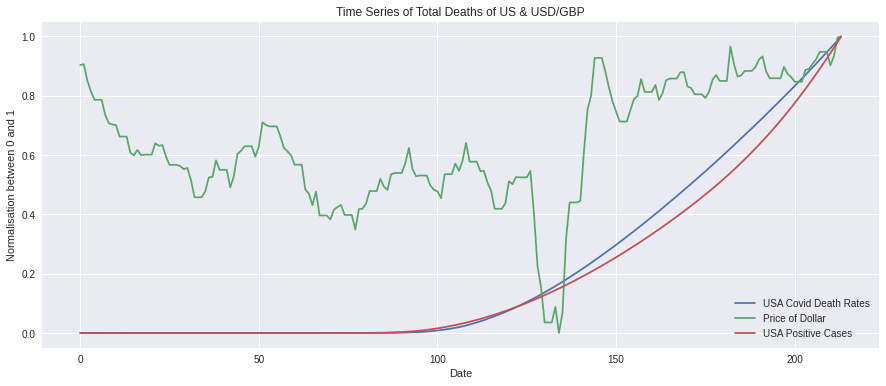

In [79]:
plt.plot(normalisation_us_deaths,label="USA Covid Death Rates")
plt.plot(normalisation_price, label="Price of Dollar")
plt.plot(normalisation_us_cases, label="USA Positive Cases")

# dates
# dates = np.array(dateFormatting['new_date'])
# plt.plot_date(dates, linestyle ='solid')
# plt.gcf().autofmt_xdate()
# date_format = mpl_dates.DateFormatter('%b,%d,%Y')
# plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()


# Splitting Data into Train, Validation & Test


In [80]:
# Creating normalised dataset
# Positive Cases | Death Rates | Price of dollar
new_dataset = np.hstack((normalisation_us_cases, normalisation_us_deaths, normalisation_price))


In [81]:
new_dataset = pd.DataFrame(new_dataset,columns=['total_cases', 'total_deaths', 'Price'])
new_dataset.head()

,total_cases,total_deaths,Price
0,0.0,0.0,0.903608
1,0.0,0.0,0.906426
2,0.0,0.0,0.850620
3,0.0,0.0,0.814543
4,0.0,0.0,0.786359


In [82]:
X = new_dataset[['total_cases','total_deaths']]
Y = new_dataset['Price']



In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0) # 20% is test size
print(X_train.shape)
print(Y_train.shape)



(171, 2)
(171,)


# Linear Regression Model

In [84]:
regressor = LinearRegression()
mld = regressor.fit(X_train, Y_train)
print(mld)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [85]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
total_cases,-1.624384
total_deaths,1.956015


In [86]:
y_pred = regressor.predict(X_test)
print(X_test.size)
print(y_pred.size)

86
43


In [87]:
df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1.sort_index(inplace=True)
df1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Actual,Predicted
5,0.786359,0.532021
12,0.662345,0.532021
37,0.525930,0.532020
55,0.696731,0.532018
74,0.397971,0.532000
75,0.397971,0.531989
83,0.478579,0.531450
89,0.539459,0.529441
96,0.531003,0.525157
112,0.545660,0.532028


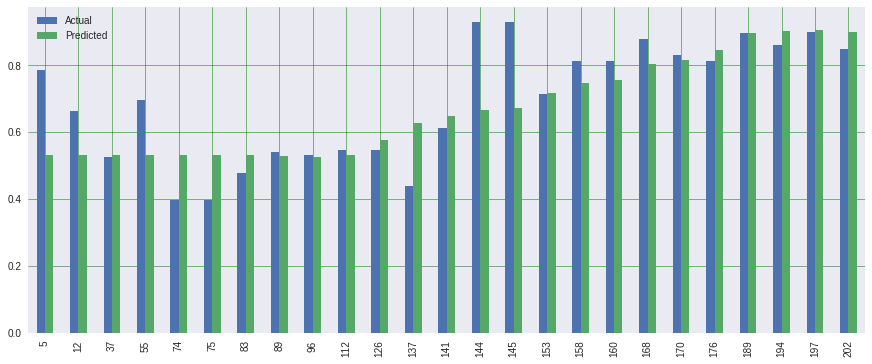

In [103]:
rcParams['figure.figsize'] = 15,6
df1.plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Performance Metric

*   How well is model performing? A measure of what i am predicting and what should have been predicting.
*  **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. 
*   **Mean Squared Error**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
* [MAE Versus RMSE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)





In [89]:
from sklearn.metrics import mean_absolute_error
# print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, y_pred))

0.08145882590700924


In [90]:
from sklearn.metrics import mean_squared_error
# print(math.sqrt(mean_squared_error(Y_train, train_predict)))
print(math.sqrt(mean_squared_error(Y_test, y_pred)))

0.11537488560548993


In [91]:
print(X_test.size)
print(Y_test.size)

86
43


In [92]:
print(X.size)
print(Y.size)

428
214


In [93]:
# print(X_test)
# print(Y_test)
Y_test_frame = pd.DataFrame(Y_test)
Y_test_frame.shape 
print(X_train.shape)
print(Y_test_frame.shape)


(171, 2)
(43, 1)


In [95]:
# 1) Only plot 1 part of X at once (i.e. X[:, 0]  ) since the first dimension is identical to Y 
# or 
# 2) Reshape X with np.reshape(X_test, -1)  and zero pad your Y to have the same length. The "-1" 
# in reshape means that numpy tries to figure out the dimension by itself, which, in this case is 43*2 = 86

In [96]:
def get_plot (model_pred):
  plt.scatter(model_pred, Y_test, color="gray")
  plt.plot(Y_test, Y_test, color='red', linewidth=2)

Text(0, 0.5, 'Price of USD/GBP & Gas Prices')

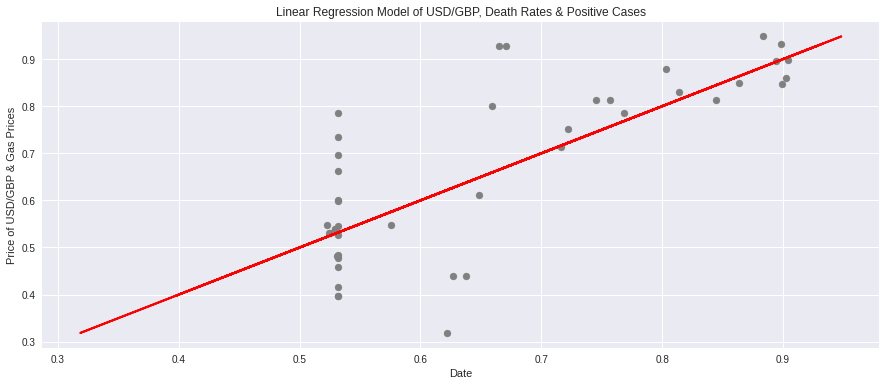

In [100]:
rcParams['figure.figsize'] = 15,6
get_plot(y_pred)
plt.title('Linear Regression Model of USD/GBP, Death Rates & Positive Cases')
plt.xlabel('Date')
plt.ylabel('Price of USD/GBP & Gas Prices')

[Saw online](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

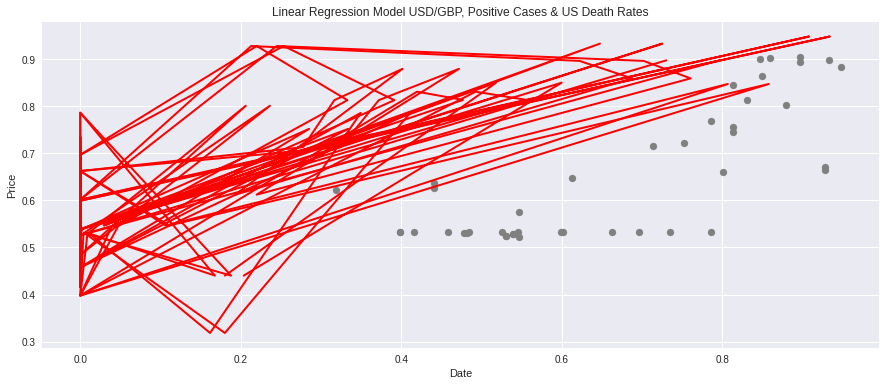

In [98]:
plt.scatter(Y_test, y_pred,  color='gray')
plt.plot(X_test, Y_test, color='red', linewidth=2)
plt.title('Linear Regression Model USD/GBP, Positive Cases & US Death Rates')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



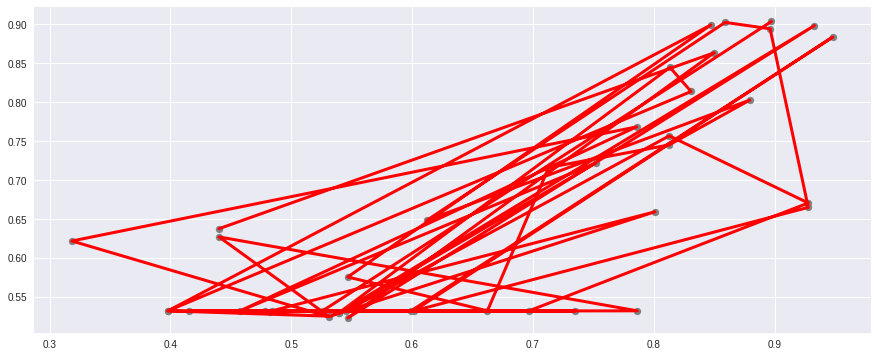

In [99]:
plt.scatter(Y_test, y_pred, color = 'gray', label='Scatter Plot')
plt.plot(Y_test, y_pred, color = 'red', linewidth=3, label = 'Regression Line')
# plt.plot(X_test, Y_test, color = 'red', linewidth=3, label = 'Regression Line')

plt.show()


# Conclusion and next steps

After exploring the Multivariate Linear Regression algorithm:
*   Notes on overfitting

In conclusion it seems that ..